In [1]:
import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from safetensors.torch import load_file
from tqdm.auto import tqdm

import wandb
api = wandb.Api()

/n/home04/ericjm/.conda/envs/narrow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load up pruning recovery runs

In [2]:
username = "ericjmichaud_"
project_name = "huggingface"
run_dir = "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00"

runs = api.runs(f"{username}/{project_name}")
run_ids_pruning = {}
for run in runs:
    if run_dir in run.name:
        run_ids_pruning[run.name] = run.id
print(run_ids_pruning.keys())

data_pruning = {}
for i, (run_name, run_id) in tqdm(enumerate(run_ids_pruning.items())):
    try:
        run = api.run(f"{username}/{project_name}/{run_id}")
        config = run.config
        summary = run.summary
        history = pd.DataFrame(list(run.scan_history()))
        data_pruning[run_name] = {
            "config": config,
            "summary": summary,
            "history": history
        }
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

dict_keys(['/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/tp15_lambda0.0005_70k_sparsity0.3', '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/tp15_lambda0.0003_70k_sparsity0.63', '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/tp15_lambda0.001_70k_sparsity0.8', '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/baseline_sparsity0.8'])


4it [00:07,  1.80s/it]


In [3]:
group_lasso_runs = {
    '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/tp15_lambda0.0005_70k_sparsity0.3',
    '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/tp15_lambda0.0003_70k_sparsity0.63',
    '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/tp15_lambda0.001_70k_sparsity0.8',
}

group_lasso_names = [
    'group lasso λ=0.0005, 70k steps',
    'group lasso λ=0.0003, 70k steps',
    'group lasso λ=0.001, 70k steps',
]

baseline_run = '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain00/baseline_sparsity0.8'

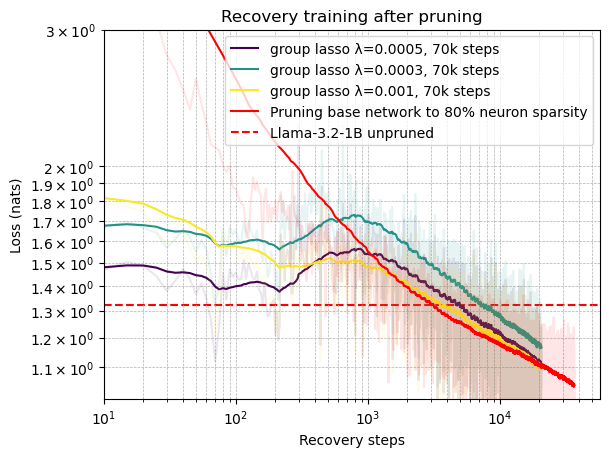

In [4]:
colors = plt.cm.viridis(np.linspace(0, 1, len(group_lasso_runs)))
for i, run_name in enumerate(group_lasso_runs):
    try:
        run_id = run_ids_pruning[run_name]
        history = data_pruning[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.1)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=group_lasso_names[i])
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

history = data_pruning[baseline_run]["history"]
plt.plot(history['train/global_step'], history['train/loss'], color='red', alpha=0.1)
ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
plt.plot(history['train/global_step'], ema_loss, color='red', label=r"Pruning base network to 80% neuron sparsity")

with open("../experiments/tuneprune15/base-attribution/sparsity_0.0/evaluation_results.json", "r") as f:
    data = json.load(f)
    baseline_loss = data["mean_loss"]
# plot horizontal line at baseline loss
plt.axhline(y=baseline_loss, color='red', linestyle='--', label="Llama-3.2-1B unpruned", zorder=-10)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1, None)
# add fine grid
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.yticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])
plt.ylim(1.0, 3)
plt.legend()
plt.title("Recovery training after pruning")
plt.xlabel("Recovery steps")
plt.ylabel("Loss (nats)")
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


(0.7282316309341695, 5.0)

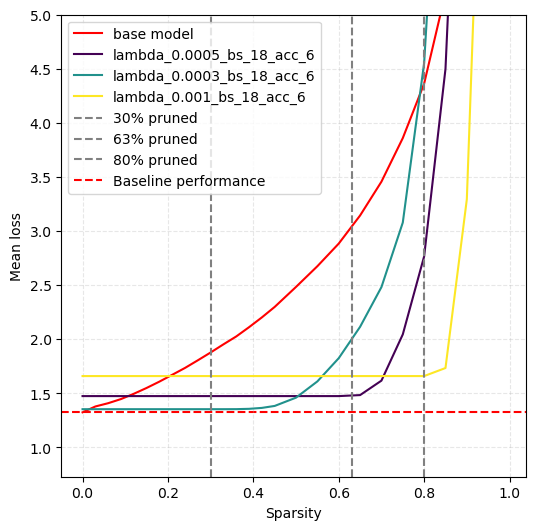

In [5]:
plt.figure(figsize=(6, 6))

exp = "../experiments/tuneprune15/base-attribution"
dirs = [d for d in os.listdir(exp) if d.startswith("sparsity")]
files = [os.path.join(exp, d, "evaluation_results.json") for d in dirs]
mean_losses = []
std_of_mean_losses = []
frac_neurons_pruned = []
for file in files:
    with open(file, "r") as f:
        data = json.load(f)
    mean_losses.append(data["mean_loss"])
    std_of_mean_losses.append(data["std_of_mean"])
    total_neurons_pruned = data["pruning_stats"]["total_neurons_pruned"]
    total_neurons = data["pruning_stats"]["total_neurons"]
    frac_remaining = (total_neurons - total_neurons_pruned) / total_neurons
    frac_neurons_pruned.append(total_neurons_pruned / total_neurons)
frac_neurons_pruned, mean_losses, std_of_mean_losses = zip(*sorted(zip(frac_neurons_pruned, mean_losses, std_of_mean_losses)))
plt.plot(frac_neurons_pruned, mean_losses, label="base model", color='red')
# plt.errorbar(frac_neurons_pruned, mean_losses, yerr=std_of_mean_losses, fmt="o", label="base model", markersize=3)

runs = [
    "lambda_0.0005_bs_18_acc_6",
    "lambda_0.0003_bs_18_acc_6",
    "lambda_0.001_bs_18_acc_6"
]
checkpoint = 70_000

colors = plt.cm.viridis(np.linspace(0, 1, len(runs)))
for run in tqdm(runs):
    exp = f"../experiments/tuneprune15/tune-attribution/{run}/checkpoint-{checkpoint}"
    dirs = [d for d in os.listdir(exp) if d.startswith("sparsity")]
    files = [os.path.join(exp, d, "evaluation_results.json") for d in dirs]
    mean_losses = []
    std_of_mean_losses = []
    frac_neurons_remaining = []
    frac_neurons_pruned = []
    for file in files:
        try:
            with open(file, "r") as f:
                data = json.load(f)
            mean_losses.append(data["mean_loss"])
            std_of_mean_losses.append(data["std_of_mean"])
            total_neurons_pruned = data["pruning_stats"]["total_neurons_pruned"]
            total_neurons = data["pruning_stats"]["total_neurons"]
            frac_remaining = (total_neurons - total_neurons_pruned) / total_neurons
            frac_neurons_remaining.append(frac_remaining)
            frac_neurons_pruned.append(total_neurons_pruned / total_neurons)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
    frac_neurons_pruned, mean_losses, std_of_mean_losses = zip(*sorted(zip(frac_neurons_pruned, mean_losses, std_of_mean_losses)))
    plt.plot(frac_neurons_pruned, mean_losses, color=colors[runs.index(run)], label=run)

with open("../experiments/tuneprune15/base-attribution/sparsity_0.0/evaluation_results.json", "r") as f:
    data = json.load(f)
    baseline_loss = data["mean_loss"]

# draw vertical lines at pruning ratios [0.3, 0.63, 0.8]
plt.axvline(x=0.3, color='grey', linestyle='--', label="30% pruned")
plt.axvline(x=0.63, color='grey', linestyle='--', label="63% pruned")
plt.axvline(x=0.8, color='grey', linestyle='--', label="80% pruned")

plt.xlabel("Sparsity")
plt.ylabel("Mean loss")
plt.axhline(y=baseline_loss, color='red', linestyle='--', label="Baseline performance", zorder=-10)
# plt.yscale('log')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 1.1, 0.2))  # Add more ticks from 0 to 1 with 0.1 intervals
plt.legend(loc='upper left', prop={'size': 10})
# plt.ylim(1, 7)
plt.ylim(None, 5)

In [8]:
import matplotlib.ticker as ticker

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 13.68it/s]


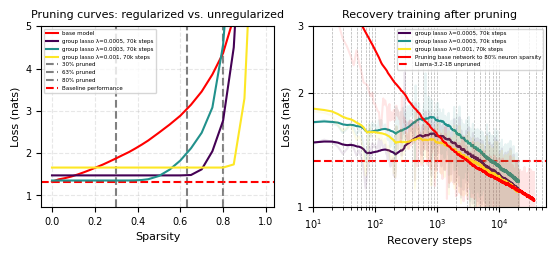

In [17]:
plt.figure(figsize=(5.5, 2.5))

plt.subplot(1, 2, 1)

exp = "../experiments/tuneprune15/base-attribution"
dirs = [d for d in os.listdir(exp) if d.startswith("sparsity")]
files = [os.path.join(exp, d, "evaluation_results.json") for d in dirs]
mean_losses = []
std_of_mean_losses = []
frac_neurons_pruned = []
for file in files:
    with open(file, "r") as f:
        data = json.load(f)
    mean_losses.append(data["mean_loss"])
    std_of_mean_losses.append(data["std_of_mean"])
    total_neurons_pruned = data["pruning_stats"]["total_neurons_pruned"]
    total_neurons = data["pruning_stats"]["total_neurons"]
    frac_remaining = (total_neurons - total_neurons_pruned) / total_neurons
    frac_neurons_pruned.append(total_neurons_pruned / total_neurons)
frac_neurons_pruned, mean_losses, std_of_mean_losses = zip(*sorted(zip(frac_neurons_pruned, mean_losses, std_of_mean_losses)))
plt.plot(frac_neurons_pruned, mean_losses, label="base model", color='red')
# plt.errorbar(frac_neurons_pruned, mean_losses, yerr=std_of_mean_losses, fmt="o", label="base model", markersize=3)

runs = [
    "lambda_0.0005_bs_18_acc_6",
    "lambda_0.0003_bs_18_acc_6",
    "lambda_0.001_bs_18_acc_6"
]

checkpoint = 70_000

colors = plt.cm.viridis(np.linspace(0, 1, len(runs)))
for run in tqdm(runs):
    exp = f"../experiments/tuneprune15/tune-attribution/{run}/checkpoint-{checkpoint}"
    dirs = [d for d in os.listdir(exp) if d.startswith("sparsity")]
    files = [os.path.join(exp, d, "evaluation_results.json") for d in dirs]
    mean_losses = []
    std_of_mean_losses = []
    frac_neurons_remaining = []
    frac_neurons_pruned = []
    for file in files:
        try:
            with open(file, "r") as f:
                data = json.load(f)
            mean_losses.append(data["mean_loss"])
            std_of_mean_losses.append(data["std_of_mean"])
            total_neurons_pruned = data["pruning_stats"]["total_neurons_pruned"]
            total_neurons = data["pruning_stats"]["total_neurons"]
            frac_remaining = (total_neurons - total_neurons_pruned) / total_neurons
            frac_neurons_remaining.append(frac_remaining)
            frac_neurons_pruned.append(total_neurons_pruned / total_neurons)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
    frac_neurons_pruned, mean_losses, std_of_mean_losses = zip(*sorted(zip(frac_neurons_pruned, mean_losses, std_of_mean_losses)))
    plt.plot(frac_neurons_pruned, mean_losses, color=colors[runs.index(run)], label=group_lasso_names[runs.index(run)])

with open("../experiments/tuneprune15/base-attribution/sparsity_0.0/evaluation_results.json", "r") as f:
    data = json.load(f)
    baseline_loss = data["mean_loss"]

# draw vertical lines at pruning ratios [0.3, 0.63, 0.8]
plt.axvline(x=0.3, color='grey', linestyle='--', label="30% pruned", zorder=-10)
plt.axvline(x=0.63, color='grey', linestyle='--', label="63% pruned", zorder=-10)
plt.axvline(x=0.8, color='grey', linestyle='--', label="80% pruned", zorder=-10)
# plt.plot(
#     [0.3, 0.63, 0.8],
#     [baseline_loss, baseline_loss, baseline_loss], 
#     color='red', linestyle='--', label="Llama-3.2-1B unpruned", zorder=10, colors=colors)

plt.xlabel("Sparsity", fontsize=8)
plt.ylabel("Loss (nats)", fontsize=8)
plt.axhline(y=baseline_loss, color='red', linestyle='--', label="Baseline performance", zorder=-10)
# plt.yscale('log')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc='upper left', prop={'size': 4})
# plt.ylim(1, 7)
plt.ylim(None, 5)
plt.title("Pruning curves: regularized vs. unregularized", fontsize=8)



plt.subplot(1, 2, 2)

colors = plt.cm.viridis(np.linspace(0, 1, len(group_lasso_runs)))
for i, run_name in enumerate(group_lasso_runs):
    try:
        run_id = run_ids_pruning[run_name]
        history = data_pruning[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.1)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=group_lasso_names[i])
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

history = data_pruning[baseline_run]["history"]
plt.plot(history['train/global_step'], history['train/loss'], color='red', alpha=0.1)
ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
plt.plot(history['train/global_step'], ema_loss, color='red', label=r"Pruning base network to 80% neuron sparsity")

with open("../experiments/tuneprune15/base-attribution/sparsity_0.0/evaluation_results.json", "r") as f:
    data = json.load(f)
    baseline_loss = data["mean_loss"]
# plot horizontal line at baseline loss
plt.axhline(y=baseline_loss, color='red', linestyle='--', label="Llama-3.2-1B unpruned", zorder=-10)

plt.xscale('log')
plt.yscale('log')

ax = plt.gca()
ax.yaxis.set_major_locator(ticker.FixedLocator([1, 2, 3]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(["1", "2", "3"]))
# else:
#     ax.yaxis.set_major_formatter(ticker.NullFormatter())  # hides major tick labels
#     ax.yaxis.set_minor_formatter(ticker.NullFormatter())  # hides minor tick labels

plt.xlim(1e1, None)
# add fine grid
plt.grid(which='both', linestyle='--', linewidth=0.5)
# plt.yticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0], fontsize=7)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.ylim(1.0, 3)
plt.legend(prop={'size': 4})
plt.title("Recovery training after pruning", fontsize=8)
plt.xlabel("Recovery steps", fontsize=8)
plt.ylabel("Loss (nats)", fontsize=8)

plt.tight_layout(pad=0.5)
plt.savefig("figures/pruning-and-recovery-curves.pdf")